[Emo-DB dataset](https://www.kaggle.com/piyushagni5/berlin-database-of-emotional-speech-emodb)

It's foulder named `wav` should be in the same directory as this notebook

anger | boredom | disgust | anxiety/fear | happiness | sadness | neutral
--- | --- | --- | --- | --- | --- | ---
W | L | E | A | F | T | N 

# Loading data

In [1]:
import os
import numpy as np
from scipy.io import wavfile
        
def _load_emo_db(file_path):
    e2c = {'W': 0, 'L': 1, 'E': 2, 'A': 3, 'F': 4, 'T': 5, 'N': 6} #emotion code to class number
    code = lambda file_name: e2c[file_name.split('.')[0][-2:-1]] #get emotion code
    raw_data, labels = [], []
    for file_name in os.listdir(file_path):
        samplerate, data = wavfile.read(file_path+file_name)
        raw_data.append(data)
        labels.append(code(file_name))
    return raw_data, labels

class Dataset():
    '''class for dataset manipulation'''
    def __init__(self):
        self.raw_data = None
        self.data = None
        self.labels = None
        
    def load_data(self, file_path, load_function=_load_emo_db):
        self.raw_data, self.labels = load_function(file_path)
        return self.raw_data, self.labels
    
    def transform_data(self, sample_transform_function, *args, raw_data=False):
        if raw_data:
            data = self.raw_data
        else:
            data = self.data
        new_data = []
        for i, sample in enumerate(data):
            new_data.append(sample_transform_function(sample, *args))
            print(f"{i+1}/{len(data)}", end='\r')
        self.data = new_data
        print("Done!           ")
        return self.data
    
    def get_raw_data(self):
        return self.raw_data
    
    def get_data(self):
        return self.data
    
    def get_dataset(self):
        return self.data, self.labels

In [2]:
dataset = Dataset()
dataset.load_data('wav/');

/usr/local/lib/python3.6/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


# Preprocessing

### Wavelet transform

In [3]:
import pywt

def wavelet_transform(sample, lvl, wavelets):
    features = []
    for wvlt in wavelets:
        coeffs = pywt.wavedec(sample, wvlt, level=lvl)
        features.append(coeffs)
    return features

In [4]:
dataset.transform_data(wavelet_transform, 10, ['db1', 'db6', 'db8', 'db10'], raw_data=True);

Done!           


# Feature extraction

### Statistical feature extraction

In [34]:
len(dataset.get_data())

535

In [6]:
len(np.concatenate(dataset.get_data()[0][0]))

71227

In [7]:
import numpy as np
import scipy.stats

def zcr(data):
    count = 0
    positive_null = None
    for i in range(1, len(data)):
        if data[i-1]*data[i] < 0:
            count += 1
        elif data[i] == 0:
            if data[i-1] > 0:
                positive_null = True
            if data[i-1] < 0:
                positive_null = False
        elif data[i-1] == 0:
            if (data[i] > 0 and positive_null == False) or (data[i] < 0 and positive_null == True):
                count += 1
    return count

def lvl_stat_features(lvl_data):
    features = []
    features.append(max(lvl_data))
    features.append(np.mean(lvl_data))
    features.append(np.median(lvl_data))
    features.append(scipy.stats.iqr(lvl_data))
    features.append(np.std(lvl_data))
    features.append(zcr(lvl_data))
    features.append(scipy.stats.kurtosis(lvl_data))
    features.append(scipy.stats.skew(lvl_data))
    return features

def sample_stat_features(sample):
    stat_features = []
    for wavelet_data in sample:
        wavelet_features = []
        for lvl_data in wavelet_data:
            wavelet_features.append(lvl_stat_features(lvl_data))
        stat_features.append(np.concatenate(wavelet_features))
    return np.concatenate(stat_features)

In [8]:
sample = dataset.get_data()[0]
for wavelet_data in sample:
    for lvl_data in wavelet_data:
        pass
#         print(lvl_stat_features(lvl_data))

In [9]:
dataset.transform_data(wavelet_transform, 10, ['db1', 'db6', 'db8', 'db10'], raw_data=True);
dataset.transform_data(sample_stat_features);

Done!           
Done!           


In [10]:
print(np.array(dataset.get_data()).shape)

(535, 352)


# Student's t-test
To select most useful features

In [11]:
stat_data, data_y = dataset.get_dataset()

no_disgust_data = [stat_data[i] for i in range(len(data_y)) if data_y[i] != 2]
no_disgust_y = [data_y[i] for i in range(len(data_y)) if data_y[i] != 2]
for i in range(len(no_disgust_y)):
    if no_disgust_y[i] > 2:
        no_disgust_y[i] -= 1
stat_data = no_disgust_data
data_y = no_disgust_y

stat_data = np.array(stat_data)
data_y = np.array(data_y)

In [12]:
for i in range(7):
    print(i, np.sum([1 for y in data_y if y==i]))

0 127
1 81
2 69
3 71
4 62
5 79
6 0.0


In [ ]:
import seaborn as sns

selected_features_id = []

for e_1 in range(7):
    for e_2 in range(e_1+1, 7):
#         e_1, e_2 = 0, 1
        feat_1 = np.array([stat_data[i] for i in range(len(stat_data)) if data_y[i] == e_1])
        feat_2 = np.array([stat_data[i] for i in range(len(stat_data)) if data_y[i] == e_2])

        p_values = []
        for st in range(len(stat_data[0])):
            sample_1 = feat_1[:,st]
            sample_2 = feat_2[:,st]
            statistic, pvalue = scipy.stats.mannwhitneyu(sample_1, sample_2)
            p_values.append(pvalue)
        p_values = np.array(p_values)

        k = 2
        idx = np.argpartition(p_values, k)
        selected_features_id.append(idx[:k])
selected_features_id = np.concatenate(selected_features_id)

In [13]:
# data_X = stat_data[:,selected_features_id]
data_X = stat_data

# Model

### Simple Neural Network

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [16]:
X_train.shape

(366, 352)

In [17]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
print(X_test_scaled.shape, y_test.shape)

(123, 352) (123,)


In [19]:
import torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [19]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = None
        self.target_transform = None
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
test_data = CustomDataset(X_test_tensor, y_test_tensor)
train_data = CustomDataset(X_train_tensor, y_train_tensor)

In [20]:
import torch
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

for X, y in test_dataloader:
    print(X.shape, y.shape)

torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([6, 352]) torch.Size([6])


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print("Using {} device".format(device))

Using cuda device


In [23]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(352),
            nn.Dropout(p=0.5),
            nn.Linear(352, 50),
            nn.ReLU(),
            nn.Linear(50, 7),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = net().to(device)
print(model)

net(
  (linear_relu_stack): Sequential(
    (0): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=352, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=7, bias=True)
    (5): Softmax(dim=1)
  )
)


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [25]:
def train(dataloader, model, loss_fn, optimizer, train_loss_hist):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(train_loss / size)
    
#         if batch%100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [26]:
def test(dataloader, model, test_loss_hist):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        test_loss_hist.append(test_loss)
        
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [27]:
test_loss_hist = []
train_loss_hist = []

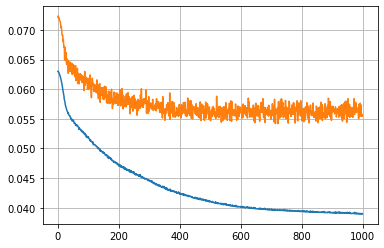

Done!


In [28]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

epochs = 1000
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss_hist)
    test(test_dataloader, model, test_loss_hist)
    clear_output(wait=True)
    if(t%50):
        plt.plot(train_loss_hist)
        plt.plot(test_loss_hist)
        plt.grid(True)
        plt.show()
print("Done!")

In [29]:
y_test_tensor = torch.tensor(y_test)
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)

In [130]:
for i in range(7):
    print(i, np.sum([1 for y in y_test if y==i]))

0 34
1 17
2 9
3 16
4 23
5 16
6 19


In [37]:
y_predict = model(X_test_tensor_device).cpu().detach().numpy()

In [144]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')

0.9275012897540226

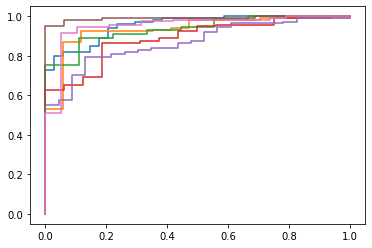

In [142]:
from sklearn.metrics import roc_curve, auc

plt.figure()

for selected_class in range(7):
    y_scores = []
    for y in y_predict:
        positive_proba = y[selected_class]
        y_scores.append([positive_proba, 1-positive_proba])

    y_predicted = np.argmax(y_scores, axis=1)
    y_score = np.array(y_scores)[:,1]

    selector = lambda x: 0 if x == selected_class else 1
    y_test_binary = [selector(y) for y in y_test]

    fpr, tpr, _ = roc_curve(y_test_binary, y_score)
    roc_auc = auc(fpr, tpr)
#     print(roc_auc)

    plt.plot(fpr, tpr)

In [136]:
accuracy_score(y_test_binary, y_predicted)

0.8805970149253731

In [135]:
for i in range(len(y_predicted)):
    print(y_predicted[i], y_test_binary[i])

1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 0
1 0
1 0
1 1
0 0
0 0
1 1
1 1
1 0
0 0
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 1
1 1
1 1
1 1
0 0
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 0
1 1
0 0
0 0
0 0
1 1
1 1
1 0
1 1
1 1
0 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
0 1
1 1
1 1
0 1
1 1
1 1
0 0
1 1
1 0
1 1
1 1
1 1
1 1
1 1
1 1
0 0
1 1
0 0
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 0
1 1
1 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
0 0
1 1
0 1
0 0
1 1
0 1
0 0
0 1
1 1
1 1
1 1
0 0
0 0
0 0


In [138]:
y_predicted =np.argmax(y_predict, axis=1)

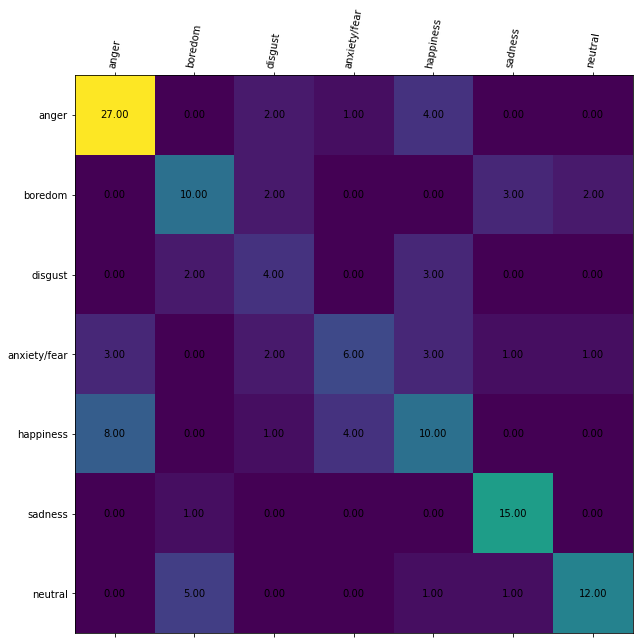

In [139]:
from sklearn.metrics import confusion_matrix

e_list = ['anger', 'boredom', 'disgust', 'anxiety/fear', 'happiness', 'sadness', 'neutral']

M = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(7), e_list, rotation=80)
plt.yticks(np.arange(7), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

In [131]:
from sklearn.metrics import accuracy_score

print('Accuracy: ' + str(accuracy_score(y_test, y_predicted)))

Accuracy: 0.3283582089552239


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [14]:
import random
a = [[1, 2], [3, 4], [5, 6]]
b = random.shuffle(a)
print(a)

[[5, 6], [1, 2], [3, 4]]


In [15]:
def data_distribution(data):
    ret = {}
    for c in np.unique(data):
        ret[c] = np.sum([1 for d in data if d == c])
    return ret

distr = data_distribution(data_y)
print(distr)
min(distr, key=distr.get)

{0: 127, 1: 81, 2: 69, 3: 71, 4: 62, 5: 79}


4

In [16]:
a = [3, 0, 1, 2]
b = np.array([12, 23, 34, 45])
b[a]

array([45, 12, 23, 34])

In [17]:
62*6

372

In [18]:
def equal_class_random_split(data_X, data_y, sampling_size=None):
    if sampling_size is None:
        sampling_size = min(distr.values())
    selected_indicies = []
    left_indicies = []
    for c in np.unique(data_y):
        class_indicies = np.array([i for i in range(len(data_y)) if data_y[i] == c])
        ind = random.sample(range(len(class_indicies)), len(class_indicies))
        selected, left = ind[:sampling_size], ind[sampling_size:]
        selected_indicies.append(class_indicies[selected])
        left_indicies.append(class_indicies[left])
        
    selected_indicies = np.concatenate(selected_indicies)
    left_indicies = np.concatenate(left_indicies)
    selected_indicies = selected_indicies[random.sample(range(len(selected_indicies)), len(selected_indicies))]
    left_indicies = left_indicies[random.sample(range(len(left_indicies)), len(left_indicies))]
    return data_X[selected_indicies], data_X[left_indicies], data_y[selected_indicies], data_y[left_indicies]
    
new_data_X, _, new_data_y, _ = equal_class_random_split(data_X, data_y)

In [53]:
X_train, X_test, y_train, y_test = equal_class_random_split(new_data_X, new_data_y, sampling_size=47)

In [36]:
# X_train, X_val, y_train, y_val = equal_class_random_split(X_train, y_train, sampling_size=42)

In [54]:
len(y_train)

282

In [55]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
from sklearn import svm
from sklearn.metrics import roc_auc_score

c_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

# X_val, y_val = X_test, y_test

for C in c_values:
    clf = svm.SVC(C=C, probability=True)
    clf.fit(X_train_scaled, y_train)
    y_predict = clf.predict_proba(X_val)
#     print(y_predict[0])
    roc_auc = roc_auc_score(y_val, y_predict, multi_class="ovo", average='macro')
    print(f'C={C}, roc_aug={roc_auc}')

C=1e-05, roc_aug=0.19499999999999998
C=0.0001, roc_aug=0.5
C=0.001, roc_aug=0.186
C=0.01, roc_aug=0.18366666666666667
C=0.1, roc_aug=0.8223333333333334
C=1, roc_aug=0.8886666666666667
C=10.0, roc_aug=0.9156666666666666
C=100.0, roc_aug=0.9326666666666665
C=1000.0, roc_aug=0.9199999999999999
C=10000.0, roc_aug=0.9233333333333333
C=100000.0, roc_aug=0.9206666666666666
C=1000000.0, roc_aug=0.919
C=10000000.0, roc_aug=0.9216666666666666
C=100000000.0, roc_aug=0.9229999999999998


In [41]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

#anger	boredom	anxiety/fear	happiness	sadness	neutral
def plot_roc(y_predict, y_test, classifier_name):
    plt.figure(figsize=(15, 10))
    mpl.rc('font',family='monospace')
    classes = [('angry', 'red'), ('boredom', 'orange'), ('fearful', 'purple'), ('happy', 'yellow'), 
                ('sad', 'royalblue'), ('neutral', 'silver')]

    for selected_class, (class_name, class_color) in enumerate(classes):
        y_scores = []
        for y in y_predict:
            positive_proba = y[selected_class]
            y_scores.append([positive_proba, 1-positive_proba])

        y_predicted = np.argmax(y_scores, axis=1)
        y_score = np.array(y_scores)[:,1]

        selector = lambda x: 0 if x == selected_class else 1
        y_test_binary = [selector(y) for y in y_test]

        fpr, tpr, _ = roc_curve(y_test_binary, y_score)
        roc_auc = auc(fpr, tpr)
    #     print(roc_auc)

        plt.plot(fpr, tpr, color=class_color, label=f'{class_name: <20}'+'(area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], '--k')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title(f'ROC curve for {classifier_name}', fontsize=20)
    plt.legend(loc="lower right", fontsize=12);
    
# plot_roc(y_predict, y_test, "Neural Network")

roc_aug=0.9645925925925928


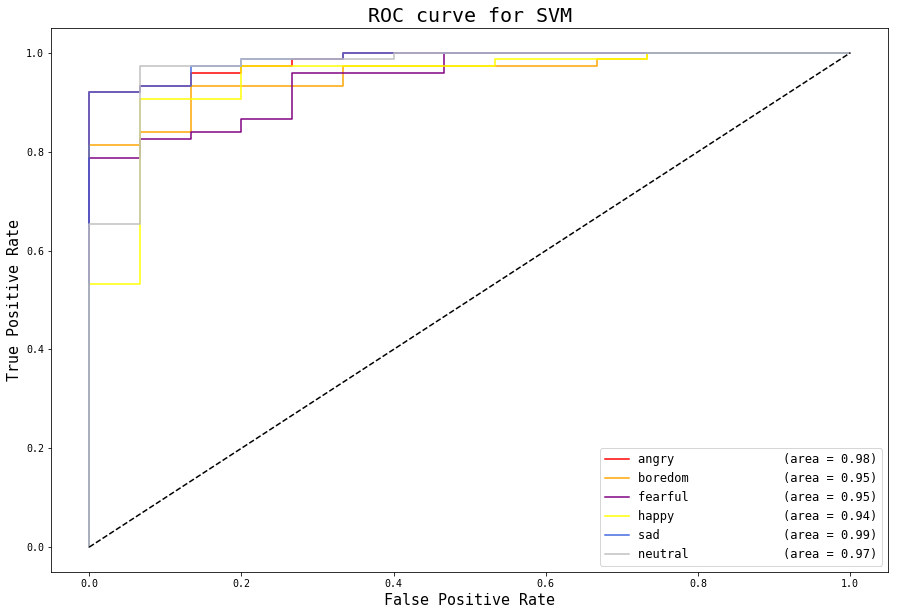

In [56]:
from sklearn import svm
from sklearn.metrics import roc_auc_score

clf = svm.SVC(C=1000, probability=True)
clf.fit(X_train_scaled, y_train)
y_predict = clf.predict_proba(X_test_scaled)
y_predicted_labels = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(f'roc_aug={roc_auc}')
plot_roc(y_predict, y_test, 'SVM')

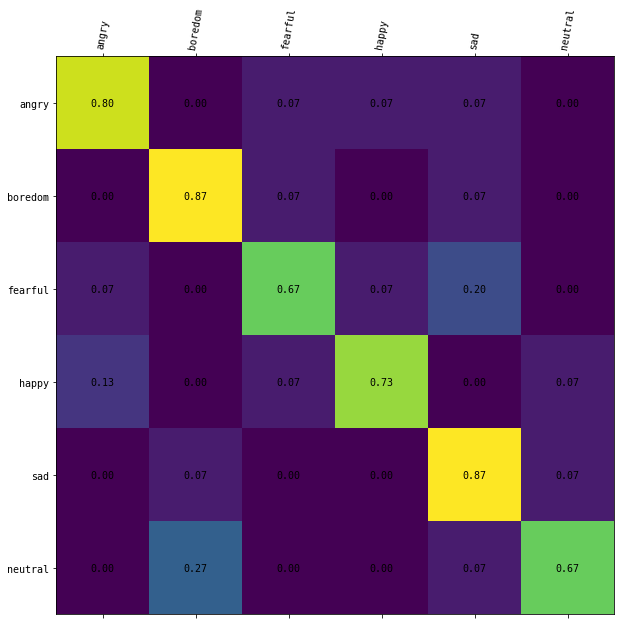

In [57]:
from sklearn.metrics import confusion_matrix
e_list = ['angry', 'boredom', 'fearful', 'happy', 'sad', 'neutral']
M = confusion_matrix(y_test, y_predicted_labels, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(6), e_list, rotation=80)
plt.yticks(np.arange(6), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

In [58]:
from sklearn.metrics import recall_score
recall_score(y_predicted_labels, y_test, average='macro')

0.77585844954266

# RAVDESS

In [44]:
def load_ravdess(file_path):
    e2c = {'01-01': 0, '02-01': 1, '02-02': 2, '03-01': 3, '03-02': 4, '04-01': 5, '04-02': 6, '05-01': 7, '05-02': 8, 
           '06-01': 9, '06-02': 10, '07-01': 11, '07-02': 12, '08-01': 13, '08-02': 14} #emotion code to class number
    code = lambda file_name: e2c[file_name[6:11]] #get emotion code
    raw_data, labels = [], []
    for folder in os.listdir(file_path):
        for file in os.listdir(file_path+folder):
            samplerate, data = wavfile.read(file_path+folder+'/'+file)
            raw_data.append(data)
            labels.append(code(file))
    return raw_data, labels

In [ ]:
dataset = Dataset()
dataset.load_data('ravdess/', load_function=load_ravdess);

In [ ]:
for i in range(len(dataset.raw_data)):
    if(len(dataset.raw_data[i].shape) != 1):
        dataset.raw_data[i] = dataset.raw_data[i][:,0]
        print('Corrected sample #{}'.format(i))

In [ ]:
from matplotlib import pyplot as plt

plt.plot(dataset.raw_data[1076])

In [ ]:
dataset.transform_data(wavelet_transform, 10, ['db1', 'db6', 'db8', 'db10'], raw_data=True);
dataset.transform_data(sample_stat_features);

In [ ]:
stat_data, data_y = dataset.get_dataset()
stat_data = np.array(stat_data)
data_y = np.array(data_y)
data_X = stat_data

In [ ]:
from numpy import savetxt

savetxt('data_x.csv', data_X, delimiter=',')
savetxt('data_y.csv', data_y, delimiter=',')

In [45]:
from numpy import loadtxt

data_X = loadtxt('data_x.csv', delimiter=',')
data_y = loadtxt('data_y.csv', delimiter=',')

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [47]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
import torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [49]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = None
        self.target_transform = None
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
test_data = CustomDataset(X_test_tensor, y_test_tensor)
train_data = CustomDataset(X_train_tensor, y_train_tensor)

In [50]:
import torch
from torch.utils.data import DataLoader

batch_size = 32

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

for X, y in test_dataloader:
    print(X.shape, y.shape)

torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([32, 352]) torch.Size([32])
torch.Size([8, 352]) torch.Size([8])


In [51]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print("Using {} device".format(device))

Using cuda device


In [52]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(352),
            nn.Dropout(p=0.5),
            nn.Linear(352, 30),
            nn.ReLU(),
            nn.Linear(30, 15),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = net().to(device)
print(model)

net(
  (linear_relu_stack): Sequential(
    (0): BatchNorm1d(352, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=352, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=15, bias=True)
    (5): Softmax(dim=1)
  )
)


In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [54]:
def train(dataloader, model, loss_fn, optimizer, train_loss_hist):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
#         print(y)
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
#         print(y, pred)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(train_loss / size)
    
#         if batch%100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [55]:
def test(dataloader, model, test_loss_hist):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        test_loss_hist.append(test_loss)
        
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [56]:
test_loss_hist = []
train_loss_hist = []

In [57]:
y_train

array([ 3.,  9., 12., ...,  4.,  0.,  6.])

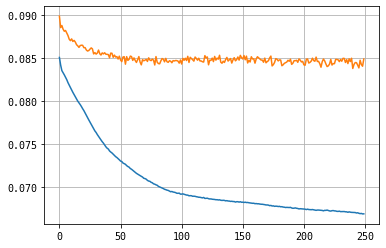

Done!


In [58]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

epochs = 250
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss_hist)
    test(test_dataloader, model, test_loss_hist)
    clear_output(wait=True)
    if(t%50):
        plt.plot(train_loss_hist)
        plt.plot(test_loss_hist)
        plt.grid(True)
        plt.show()
print("Done!")

In [59]:
y_test_tensor = torch.tensor(y_test)
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)

In [60]:
y_predict = model(X_test_tensor_device).cpu().detach().numpy()

In [67]:
y_predicted_labels = np.argmax(y_predict, axis=1)

In [68]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')

0.7464106426431636

In [69]:
a = [(1, 2), (2, 3)]
for b, c in a:
    print (b, c)

1 2
2 3


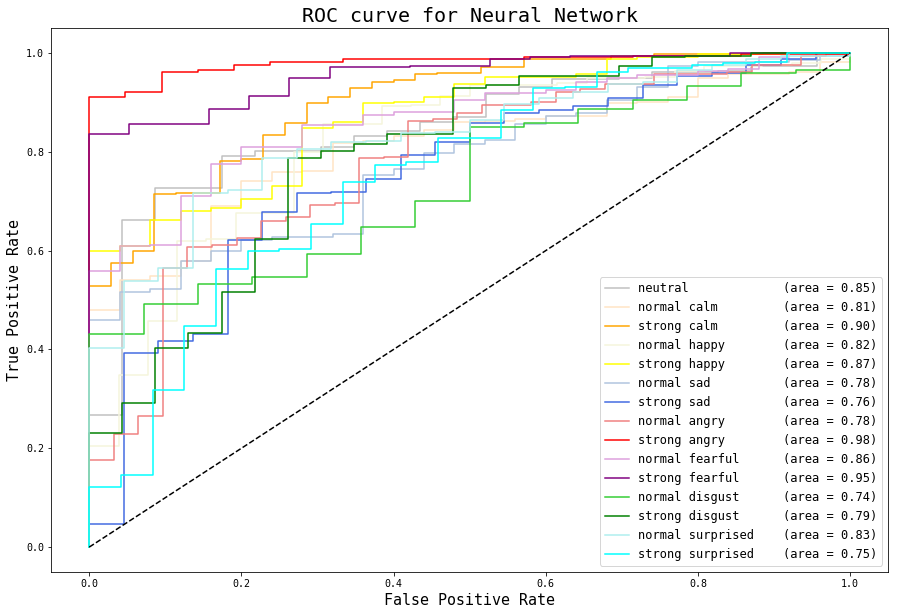

In [70]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib as mpl

def plot_roc(y_predict, y_test, classifier_name):
    plt.figure(figsize=(15, 10))
    mpl.rc('font',family='monospace')
    classes = [('neutral', 'silver'), ('normal calm', 'bisque'), ('strong calm', 'orange'), ('normal happy', 'beige'), 
               ('strong happy', 'yellow'), ('normal sad', 'lightsteelblue'), ('strong sad', 'royalblue'), 
               ('normal angry', 'lightcoral'), ('strong angry', 'red'), ('normal fearful', 'plum'), 
               ('strong fearful', 'purple'), ('normal disgust', 'limegreen'), ('strong disgust', 'green'), 
               ('normal surprised', 'paleturquoise'), ('strong surprised', 'cyan')]

    for selected_class, (class_name, class_color) in enumerate(classes):
        y_scores = []
        for y in y_predict:
            positive_proba = y[selected_class]
            y_scores.append([positive_proba, 1-positive_proba])

        y_predicted = np.argmax(y_scores, axis=1)
        y_score = np.array(y_scores)[:,1]

        selector = lambda x: 0 if x == selected_class else 1
        y_test_binary = [selector(y) for y in y_test]

        fpr, tpr, _ = roc_curve(y_test_binary, y_score)
        roc_auc = auc(fpr, tpr)
    #     print(roc_auc)

        plt.plot(fpr, tpr, color=class_color, label=f'{class_name: <20}'+'(area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], '--k')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title(f'ROC curve for {classifier_name}', fontsize=20)
    plt.legend(loc="lower right", fontsize=12);
    
plot_roc(y_predict, y_test, "Neural Network")

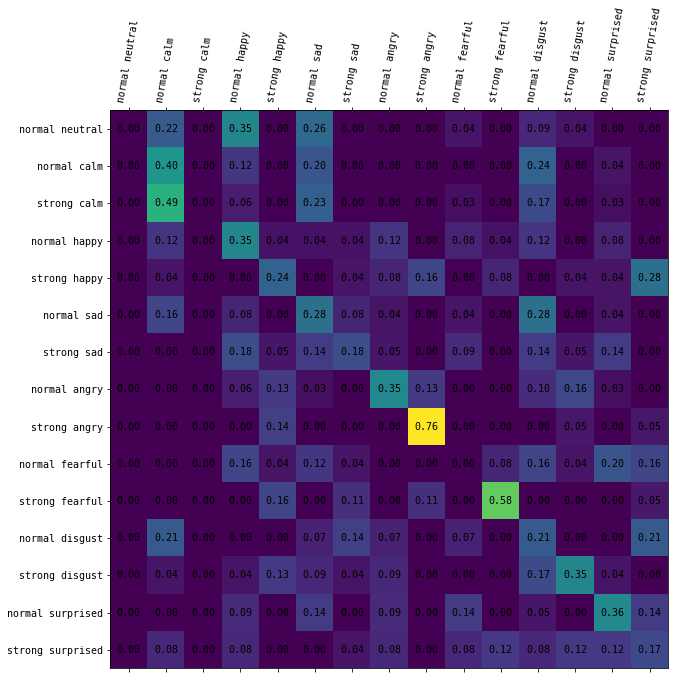

In [71]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_labels, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

In [73]:
from sklearn.metrics import accuracy_score

print('Accuracy: ' + str(accuracy_score(y_test, y_predicted_labels)))

Accuracy: 0.26944444444444443


# Let's try other classifiers

## Decision tree

In [74]:
from numpy import loadtxt

data_X = loadtxt('data_x.csv', delimiter=',')
data_y = loadtxt('data_y.csv', delimiter=',')

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [76]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [77]:
def one_hot_encoder(y, n_classes):
    encoding = np.zeros((len(y), n_classes))
    for i, j in enumerate(y):
        encoding[i][int(j)] = 1
    return encoding

a = [0.0, 2.0, 2.0, 3.0, 4.0]
one_hot_encoder(a, 5)

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [78]:
y_train_encoded = one_hot_encoder(y_train, 15)
y_test_encoded = one_hot_encoder(y_test, 15)
y_val_encoded = one_hot_encoder(y_val, 15)

In [79]:
y_train_encoded[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [80]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

depths = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    y_predict = clf.predict_proba(X_val)
    roc_auc = roc_auc_score(y_val, y_predict, multi_class="ovo", average='macro')
#     clear_output(wait=True)
    print(f'depth={depth}, roc_aug={roc_auc}')
#     plot_roc(y_predict, y_val)

depth=1, roc_aug=0.591466688073831
depth=2, roc_aug=0.7055968528533599
depth=3, roc_aug=0.7416323000173439
depth=4, roc_aug=0.7516070547464981
depth=5, roc_aug=0.7335212708154345
depth=6, roc_aug=0.7063662689355708
depth=7, roc_aug=0.6905336571688082
depth=8, roc_aug=0.6785332847889624
depth=16, roc_aug=0.6088937173277115
depth=32, roc_aug=0.6118797967495999
depth=64, roc_aug=0.6038418356239563


In [83]:
clf = DecisionTreeClassifier(max_depth=4).fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)
y_predicted_labels = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(roc_auc)

0.7526129935249548


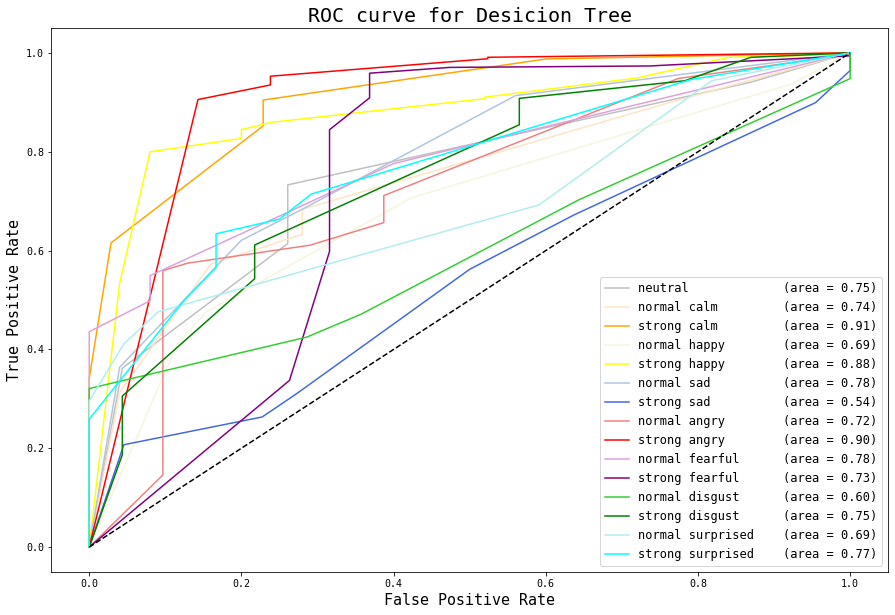

In [82]:
plot_roc(y_predict, y_test, 'Desicion Tree')

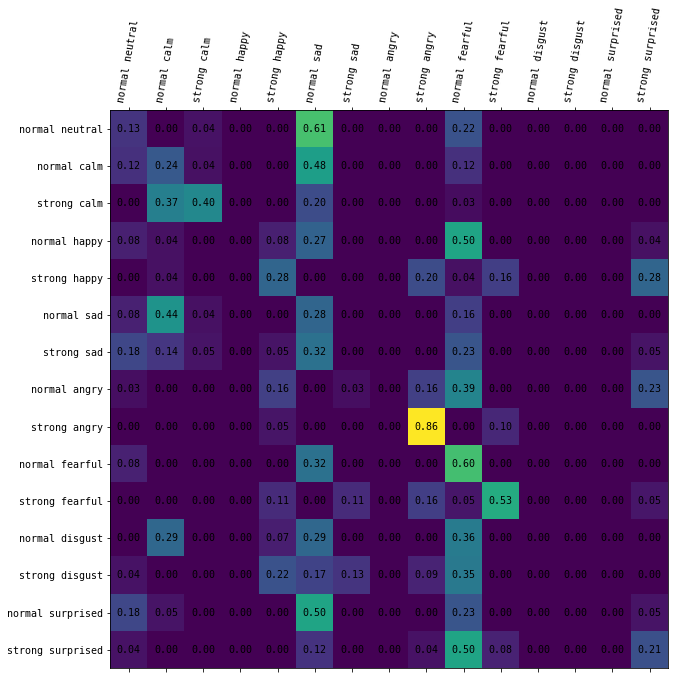

In [84]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_labels, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

## SVM

In [64]:
from numpy import loadtxt

data_X = loadtxt('data_x.csv', delimiter=',')
data_y = loadtxt('data_y.csv', delimiter=',')

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [67]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [68]:
from sklearn import svm

c_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8]

for C in c_values:
    clf = svm.SVC(C=C, probability=True)
    clf.fit(X_train_scaled, y_train)
    y_predict = clf.predict_proba(X_val_scaled)
#     print(y_predict[0])
    roc_auc = roc_auc_score(y_val, y_predict, multi_class="ovo", average='macro')
    print(f'C={C}, roc_aug={roc_auc}')

C=1e-05, roc_aug=0.7130409914227192
C=0.0001, roc_aug=0.728044231171237
C=0.001, roc_aug=0.7172786033822984
C=0.01, roc_aug=0.740086683257799
C=0.1, roc_aug=0.7466993635056139
C=1, roc_aug=0.8244417429365196
C=10.0, roc_aug=0.8491295200515715
C=100.0, roc_aug=0.8470989924205383
C=1000.0, roc_aug=0.8480218921333267
C=10000.0, roc_aug=0.8475046537649336
C=100000.0, roc_aug=0.8468381473828965
C=1000000.0, roc_aug=0.8480051850288792
C=10000000.0, roc_aug=0.8470076780804029
C=100000000.0, roc_aug=0.8483517291231577


roc_aug=0.8335533555457372


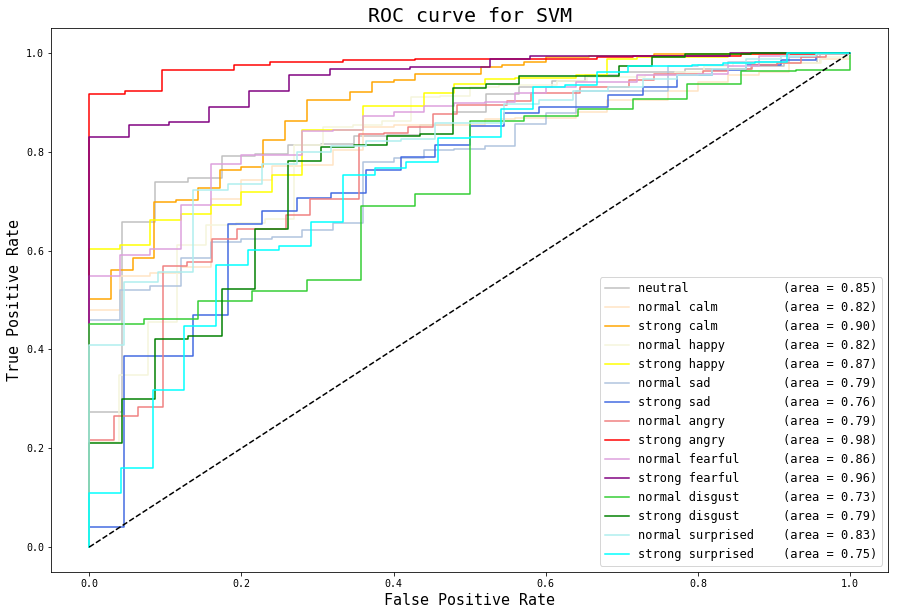

In [71]:
clf = svm.SVC(C=1000, probability=True)
clf.fit(X_train_scaled, y_train)
y_predict = clf.predict_proba(X_test_scaled)
y_predicted_labels = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(f'roc_aug={roc_auc}')
plot_roc(y_predict, y_test, 'SVM')

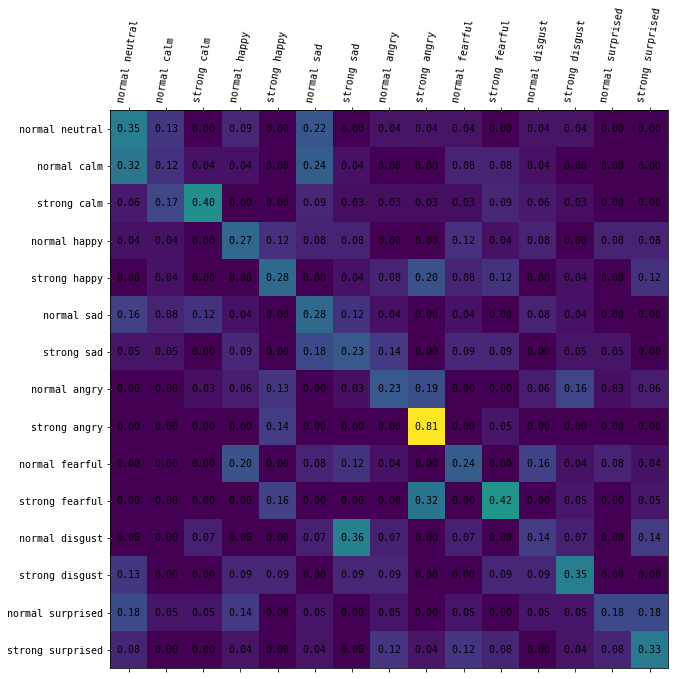

In [72]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_labels, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

## Naive Gaussian Bayes

roc_aug=0.7885863666521429


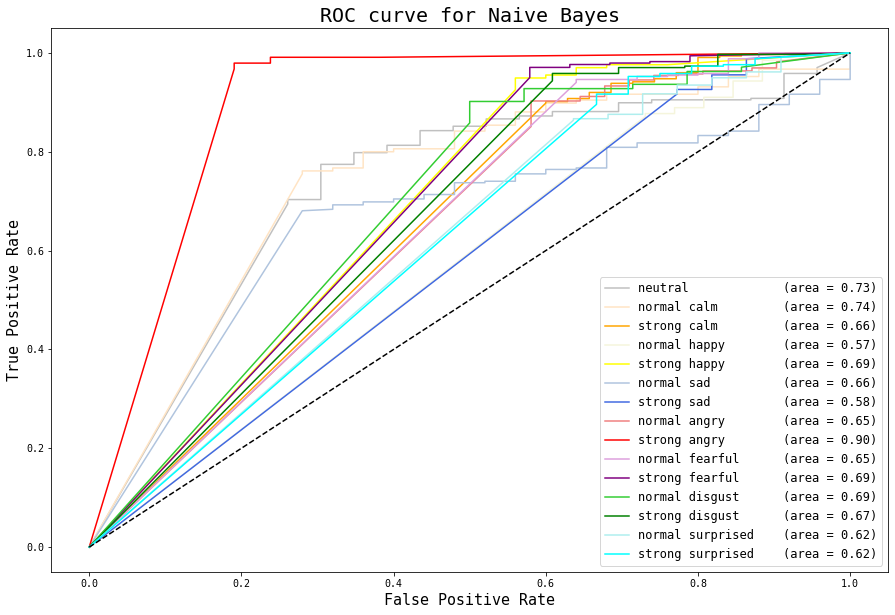

In [92]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)
y_predicted_labels = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(f'roc_aug={roc_auc}')
plot_roc(y_predict, y_test, 'Naive Bayes')

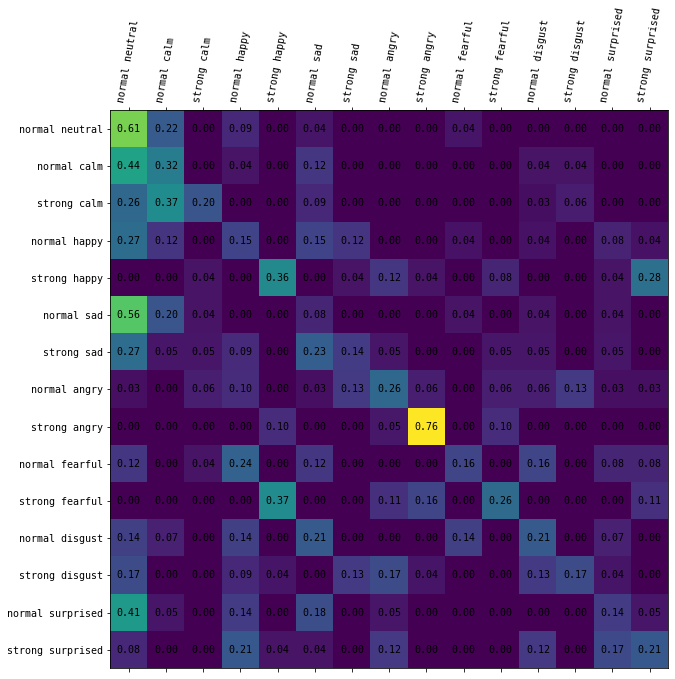

In [93]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_labels, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

# back to method 1

In [3]:
# !ls

conformer  data_x.csv  env	plotter.py  wav
data.json  data_y.csv  main.py	ravdess     WaveletTransform.ipynb


In [2]:
# !wget https://raw.githubusercontent.com/nologicexe/test/master/speech-analyzer/ravdess/data.json

--2021-06-23 00:54:13--  https://raw.githubusercontent.com/nologicexe/test/master/speech-analyzer/ravdess/data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2023723 (1,9M) [text/plain]
Saving to: ‘data.json’

data.json           100%[===================>]   1,93M  4,91MB/s    in 0,4s    

2021-06-23 00:54:13 (4,91 MB/s) - ‘data.json’ saved [2023723/2023723]



In [1]:
import json
import numpy as np

with open('data.json') as json_file:
    dataset = json.load(json_file)

In [2]:
print(len(dataset.keys()))

print(dataset['03-01-04-02-01-02-20'])

1440
[[96.0, 72.0, 96.0, 192.0, 128.0, 152.0, 176.0, 152.0, 192.0, 240.0, 272.0], [[165719.2949617069, 190052.48069374572, 280162.2786430368, 586885.2850429422, 8900278.2511653, 344828.59140862734], [185129.002020584, 196339.1944249673, 230537.60162200293, 319956.5261688527, 614674.0685142453, 4633040.6160715055], [6218.661608535821, 13859.145879163256, 21707.07022681465, 78249.02132644145, 227075.67169708334, 6181704.281957981], [515473.5172275717, 941869.1530849976, 5172326.063858338, 350483.88491168566, 2648125.0023930552, 2909290.2949597947], [180500.9022852103, 188528.2860392542, 4350720.840984274, 757434.5124580765, 515326.3784518299, 9973567.44317159], [61045.21739642548, 204485.94220889753, 1096762.4140188766, 173595.07776909534, 377111.50018850295, 82220.75937915327], [76850.3672921234, 1048039.9720865332, 416523.7525299254, 316050.453629146, 1544154.071302411, 66146.69072401208], [47408.647979943016, 335876.80529027374, 2002734.0942838797, 182875.30524574948, 189930.083484574

In [3]:
em2name = {"01-01": "normal neutral", "02-01": "normal calm", "02-02": "strong calm", "03-01": "normal happy",
            "03-02": "strong happy", "04-01": "normal sad", "04-02": "strong sad", "05-01": "normal angry",
            "05-02": "strong angry", "06-01": "normal fearful", "06-02": "strong fearful", "07-01": "normal disgust",
            "07-02": "strong disgust", "08-01": "normal surprised", "08-02": "strong surprised"}

name2num = {"normal neutral": 0, "normal calm": 1, "strong calm": 2, "normal happy": 3, "strong happy": 4,
            "normal sad": 5, "strong sad": 6, "normal angry": 7, "strong angry": 8, "normal fearful": 9, 
            "strong fearful": 10, "normal disgust": 11, "strong disgust": 12, "normal surprised": 13, "strong surprised": 14}

In [4]:
num2name = {v:k for k,v in name2num.items()}

In [5]:
key = '03-01-04-02-01-02-20'
[dataset[key][0][1]]+dataset[key][1][0]

[72.0,
 165719.2949617069,
 190052.48069374572,
 280162.2786430368,
 586885.2850429422,
 8900278.2511653,
 344828.59140862734]

In [6]:
X = []
y = []

for key, item in dataset.items():
    emotion = key[6:11]
    class_number = name2num[em2name[emotion]]
    for i in range(len(item[0])):
        features = [item[0][i]] + item[1][i]
        # print(features)
        X.append(features)
        y.append(class_number)
data_X = np.array(X)
data_y = np.array(y)
print(data_X.shape)
print(data_y.shape)

(15825, 7)
(15825,)


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)

In [21]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [22]:
import torch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [23]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.transform = None
        self.target_transform = None
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
test_data = CustomDataset(X_test_tensor, y_test_tensor)
train_data = CustomDataset(X_train_tensor, y_train_tensor)

In [24]:
import torch
from torch.utils.data import DataLoader

batch_size = 256

train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

for X, y in test_dataloader:
    print(X.shape, y.shape)

torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([256, 7]) torch.Size([256])
torch.Size([117, 7]) torch.Size([117])


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print("Using {} device".format(device))

Using cuda device


In [26]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            nn.BatchNorm1d(7),
            nn.Dropout(p=0.5),
            nn.Linear(7, 50),
            nn.ReLU(),
            nn.Linear(50, 15),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = net().to(device)
print(model)

net(
  (linear_relu_stack): Sequential(
    (0): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=7, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=15, bias=True)
    (5): Softmax(dim=1)
  )
)


In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

In [28]:
def train(dataloader, model, loss_fn, optimizer, train_loss_hist):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
#         print(y)
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
#         print(y, pred)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss_hist.append(train_loss / size)
    
#         if batch%100 == 0:
#             loss, current = loss.item(), batch * len(X)
#             print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [29]:
def test(dataloader, model, test_loss_hist):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= size
        correct /= size
        test_loss_hist.append(test_loss)
        
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [30]:
test_loss_hist = []
train_loss_hist = []

In [31]:
y_train

array([12, 11, 13, ...,  1,  6, 12])

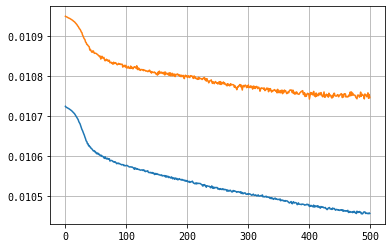

Done!


In [34]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, train_loss_hist)
    test(test_dataloader, model, test_loss_hist)
    clear_output(wait=True)
    if(t%50):
        plt.plot(train_loss_hist)
        plt.plot(test_loss_hist)
        plt.grid(True)
        plt.show()
print("Done!")

In [35]:
y_test_tensor = torch.tensor(y_test)
X_test_tensor_device = X_test_tensor.to(device)
y_test_tensor_device = y_test_tensor.to(device)

In [36]:
y_predict = model(X_test_tensor_device).cpu().detach().numpy()

In [37]:
y_predicted_label = np.argmax(y_predict, axis=1)

In [38]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
print('roc_auc_score = ', roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro'))

roc_auc_score =  0.6022901052954892


In [39]:
a = [(1, 2), (2, 3)]
for b, c in a:
    print (b, c)

1 2
2 3


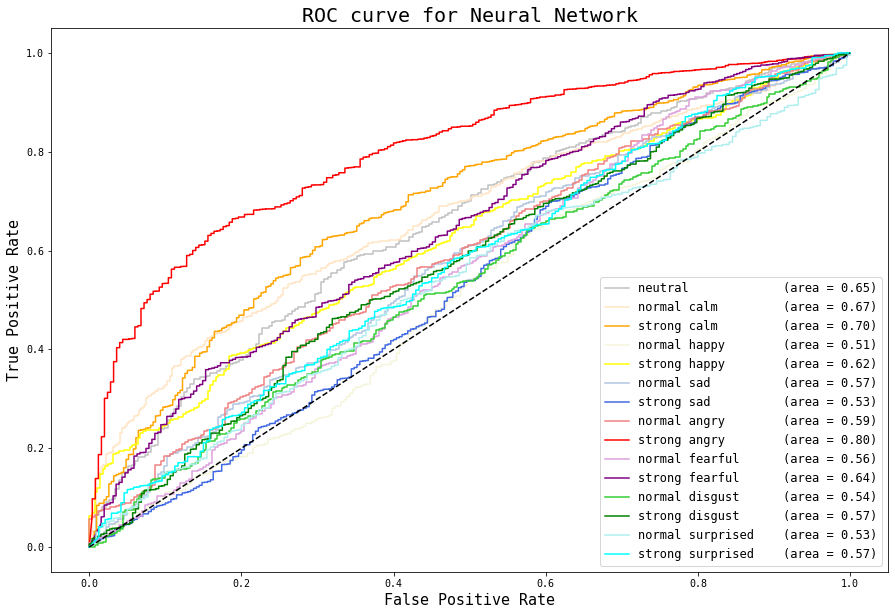

In [40]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib as mpl

def plot_roc(y_predict, y_test, classifier_name):
    plt.figure(figsize=(15, 10))
    mpl.rc('font',family='monospace')
    classes = [('neutral', 'silver'), ('normal calm', 'bisque'), ('strong calm', 'orange'), ('normal happy', 'beige'), 
               ('strong happy', 'yellow'), ('normal sad', 'lightsteelblue'), ('strong sad', 'royalblue'), 
               ('normal angry', 'lightcoral'), ('strong angry', 'red'), ('normal fearful', 'plum'), 
               ('strong fearful', 'purple'), ('normal disgust', 'limegreen'), ('strong disgust', 'green'), 
               ('normal surprised', 'paleturquoise'), ('strong surprised', 'cyan')]

    for selected_class, (class_name, class_color) in enumerate(classes):
        y_scores = []
        for y in y_predict:
            positive_proba = y[selected_class]
            y_scores.append([positive_proba, 1-positive_proba])

        y_predicted = np.argmax(y_scores, axis=1)
        y_score = np.array(y_scores)[:,1]

        selector = lambda x: 0 if x == selected_class else 1
        y_test_binary = [selector(y) for y in y_test]

        fpr, tpr, _ = roc_curve(y_test_binary, y_score)
        roc_auc = auc(fpr, tpr)
    #     print(roc_auc)

        plt.plot(fpr, tpr, color=class_color, label=f'{class_name: <20}'+'(area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], '--k')
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title(f'ROC curve for {classifier_name}', fontsize=20)
    plt.legend(loc="lower right", fontsize=12);
    
plot_roc(y_predict, y_test, "Neural Network")

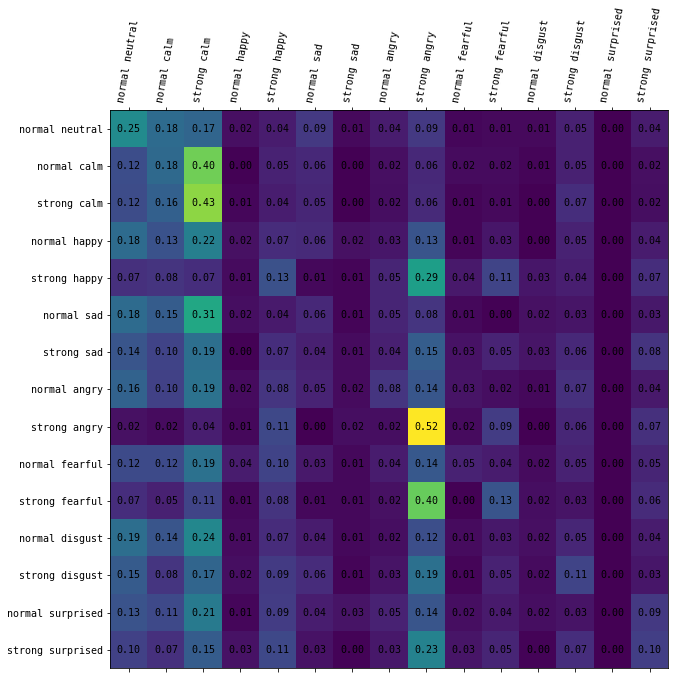

In [41]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_label, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

## Decision tree

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [10]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [62]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

depths = [1, 2, 3, 4, 5, 6, 7, 8, 16, 32, 64]

for depth in depths:
    clf = DecisionTreeClassifier(max_depth=depth).fit(X_train, y_train)
    y_predict = clf.predict_proba(X_val)
    roc_auc = roc_auc_score(y_val, y_predict, multi_class="ovo", average='macro')
#     clear_output(wait=True)
    print(f'depth={depth}, roc_aug={roc_auc}')
#     plot_roc(y_predict, y_val)

depth=1, roc_aug=0.5622951692144085
depth=2, roc_aug=0.6027234761696499
depth=3, roc_aug=0.6196004407386826
depth=4, roc_aug=0.628569860826482
depth=5, roc_aug=0.6359372439526458
depth=6, roc_aug=0.6349946042508713
depth=7, roc_aug=0.6235894446068833
depth=8, roc_aug=0.6188535995846548
depth=16, roc_aug=0.536296306167555
depth=32, roc_aug=0.518605431093277
depth=64, roc_aug=0.5162683998103348


In [65]:
clf = DecisionTreeClassifier(max_depth=6).fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)
y_predicted_label = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(roc_auc)

0.6233456939842911


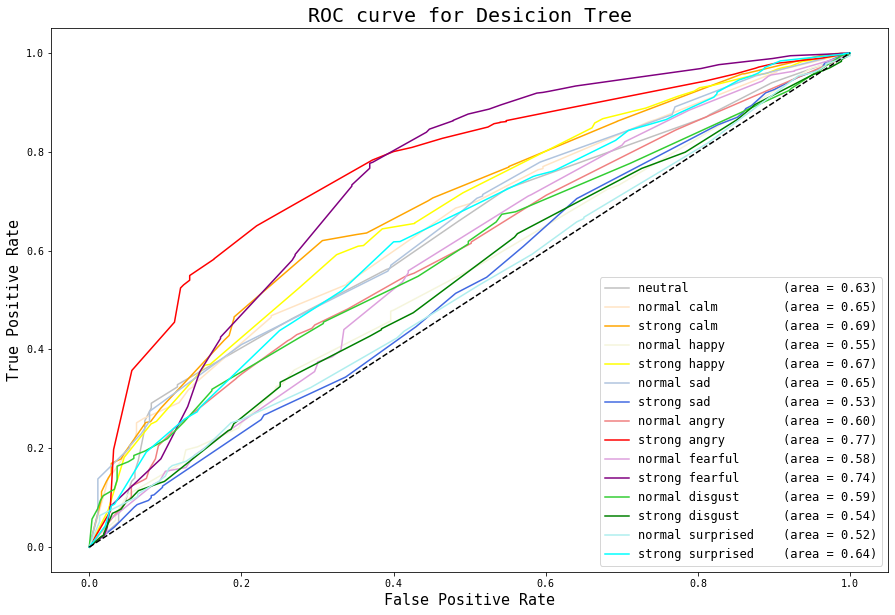

In [64]:
plot_roc(y_predict, y_test, 'Desicion Tree')

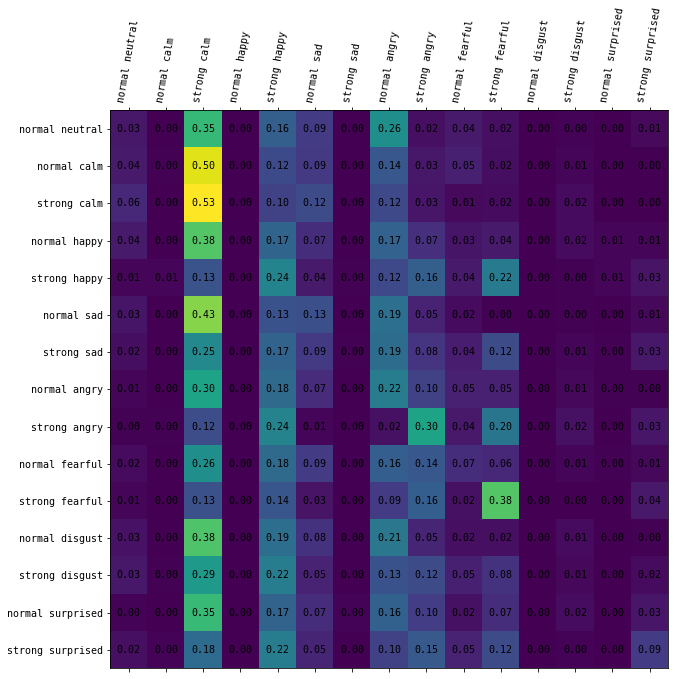

In [66]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_label, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

## svm

In [12]:
from sklearn import svm
from sklearn.metrics import roc_auc_score

c_values = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]

for C in c_values:
    clf = svm.SVC(C=C, probability=True)
    clf.fit(X_train, y_train)
    y_predict = clf.predict_proba(X_val)
#     print(y_predict[0])
    roc_auc = roc_auc_score(y_val, y_predict, multi_class="ovo", average='macro')
    print(f'C={C}, roc_aug={roc_auc}')

C=1e-05, roc_aug=0.5946488591128984
C=0.0001, roc_aug=0.5955539038081928
C=0.001, roc_aug=0.5991749756002613
C=0.01, roc_aug=0.5986535166075165
C=0.1, roc_aug=0.6065931806427904
C=1, roc_aug=0.6196485998067194
C=10.0, roc_aug=0.6257346716477725
C=100.0, roc_aug=0.6217217997145682
C=1000.0, roc_aug=0.6104721372682914


roc_aug=0.6186921960047033


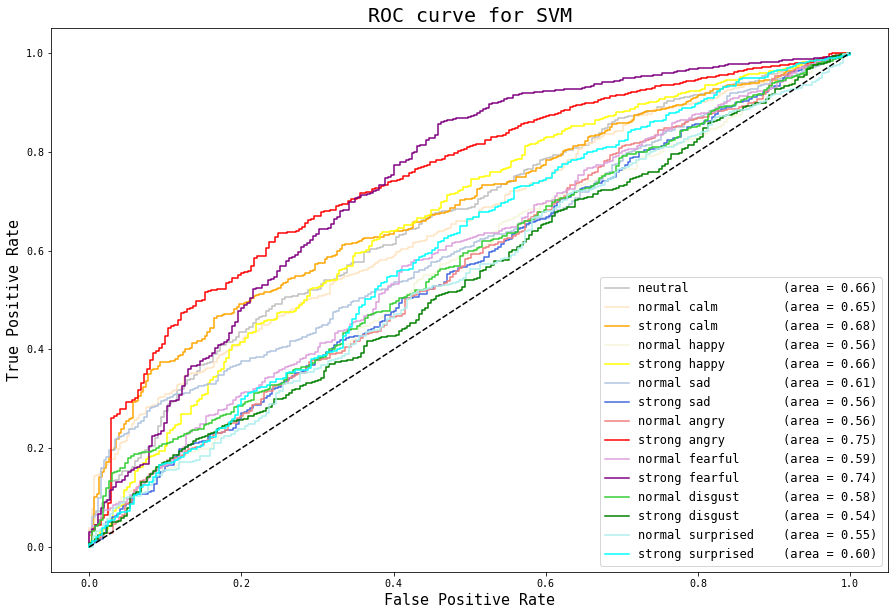

In [16]:
clf = svm.SVC(C=10, probability=True)
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)
y_predicted_label = np.argmax(y_predict, axis=1)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(f'roc_aug={roc_auc}')
plot_roc(y_predict, y_test, 'SVM')

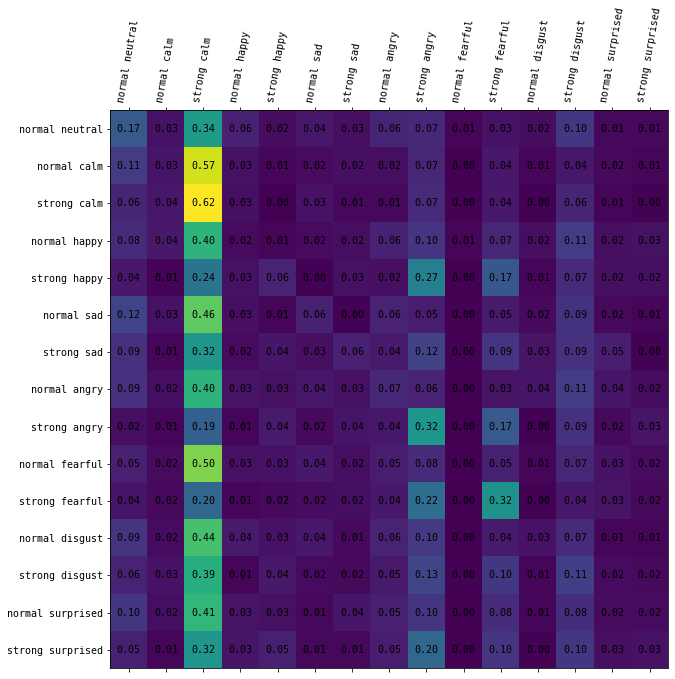

In [17]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_label, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')

## naive bayes

roc_aug=0.5752661114830327


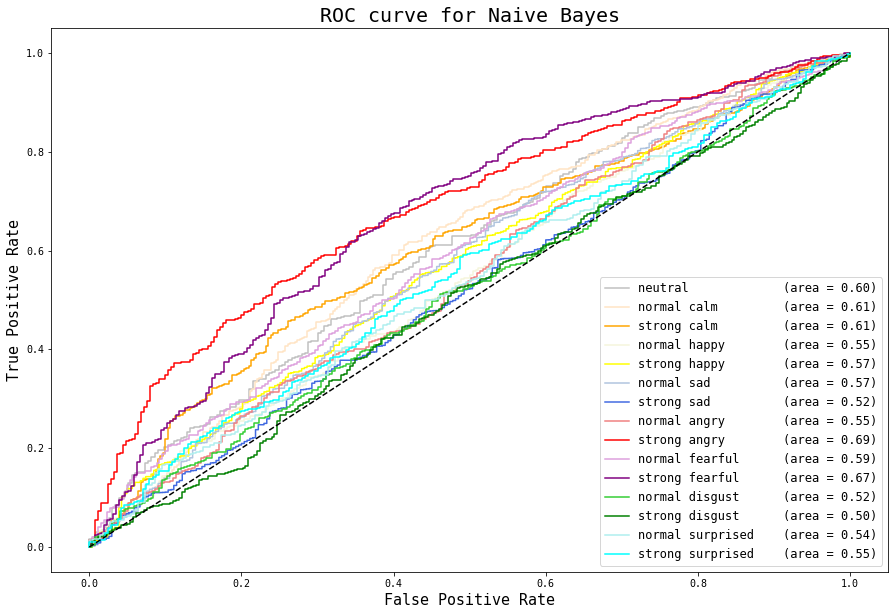

In [18]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
clf.fit(X_train, y_train)
y_predict = clf.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_predict, multi_class="ovo", average='macro')
print(f'roc_aug={roc_auc}')
plot_roc(y_predict, y_test, 'Naive Bayes')

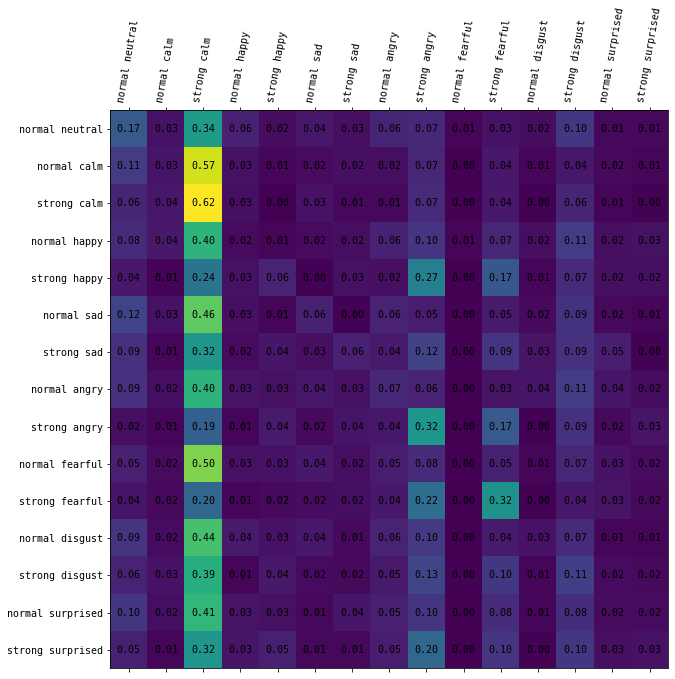

In [19]:
from sklearn.metrics import confusion_matrix
e_list = ["normal neutral", "normal calm", "strong calm", "normal happy", "strong happy", "normal sad", "strong sad", "normal angry", "strong angry", "normal fearful", "strong fearful", "normal disgust", "strong disgust", "normal surprised", "strong surprised"]
M = confusion_matrix(y_test, y_predicted_label, normalize='true')
plt.figure(figsize=(10, 10))
plt.matshow(M, fignum=1)
plt.xticks(np.arange(15), e_list, rotation=80)
plt.yticks(np.arange(15), e_list, rotation=0)
for (i, j), c in np.ndenumerate(M):
    plt.text(j, i, '{:0.2f}'.format(c), ha='center', va='center')